# Direction Finding

The direction of the sound source is here estimated by determining for the same signal the relative delays between the different hydrophones and by considering the following relation between measured delays and the direction vector of the sound source. 

The minimal number of hydrophones to form a volumetric array is 4 allowing to form n = 6 different hydrophone pairs.
To obtain an optimal volumetric array the hydrophones are located on the tips of an tetrahedron. This way all 6 hydrophone pairs have the same separation.
While direction finding could be done with only 3 hydrophone pairs, the use of all 6 different combinations should improve the performance, as the impact of measurement errors is reduced. 
This is reflected by the Least-Mean-Square notation in equation. 
Also, using all possible hydrophone pairs puts the reference location of the array automatically in the center of the array eliminating the need for a selection of a reference hydrophone.

A volumetric array with 6 hydrophones allows the formation of n = 15 different pairs of hydrophones. If the hydrophones are located on the tips of an octohedron, 12 of the 15 hydrophone pairs have the same length, and 3 are slightly longer.

## Basic formulation
Let the sound direction  $\hat s$ be given by 
\begin{equation}
    \hat s = 
    \left(
        \begin{array}{c}
            s_x\\
            s_y\\
            s_z
        \end{array}
    \right)  
\end{equation}
and the hydrophone separation matrix $ D_0$ be given by

\begin{equation}
     D_0 = 
    \left(
        \begin{array}{c c c c}
            d_{1x} & d_{2x} & ... & d_{nx}\\
            d_{1y} & d_{2y} & ... & d_{ny}\\
            d_{1z} & d_{2z} & ... & d_{nz}\\
        \end{array}
    \right)  
\end{equation}
where the elements $(d_{ix},d_{iy},d_{iz}) $ are the $x,y,z$ components of the vector that connects a pair of hydrophones.

then the vector of measurements $ m$ defined by 
\begin{equation}
     m = 
    \left(
        \begin{array}{c}
            m_1\\
            m_2\\
            \vdots\\
            m_n
        \end{array}
    \right)  
\end{equation}

is estimated by the projection of the sound source direction onto the different hydrophone pairs.


\begin{equation}
     m =  D_0^T  {\hat s}
\end{equation}

The sound direction is then estimated from the measurement vector by

\begin{equation}
    {\hat s} = \left( D_0^T  D_0 \right)^{-1}  D_0  m
\end{equation}


## Angle estimations

The arrival angles azimuth $\alpha$ and elevation $\beta$  of the sound are finally estimated by solving

\begin{equation}
    \tan \alpha = \frac{-s_y}{s_x}
\end{equation}

and

\begin{equation}
    \sin \beta = s_z
\end{equation}

or alternatively

\begin{equation}
    \tan \beta = \frac{s_z}{\sqrt{s_x^2+s_y^2}}
\end{equation}

As the azimuth angles may vary from -180°  to 180°  the solutions require the usual care for  $s_x<0$, i.e. by using the four-quadrant inverse tangent. 
The minus sign in equation is simply due to the convention that positive azimuth is measured towards starboard. 

As the elevation angle $\beta$ is restricted to ±90°, an ordinary inverse sinus is sufficient but a four-quadrant inverse tangent seems also here preferred because it is insensitive to a common factor (e.g. uncertain sound speed at the array).

## Implementation
The following function demonstrates the generation of the matrix $DI = \left( D_0^T  D_0 \right)^{-1}  D_0$ that is multiplied with the measurement vector to obtain the sound direction. 

The two hydrophone arrays are two systems that have been used (cPAM) or are in use by the author (cVAS).


In [564]:
import numpy as np

def hydrophones(model='cVAS'):
    if model=='cVAS':
        # cVAS hydrophones
        # octahedron (x points from 'centre' towards hydrophone 1)
        ro=0.040 # m
        dz=np.sqrt(2)
        ang=np.array([0,120,240,60,180,300])*np.pi/180
        #
        ho=np.empty((len(ang),3))
        ho[:,:]=np.transpose([np.cos(ang[:]),np.sin(ang[:]),-dz/2+0*ang[:]])
        ho[3:,2] += dz
        ho *= ro
    if model=='cPAM':
        # cPAM hydrophones
        # tripple towed array (x points forward, 'towards hydrophone 1)
        ro=0.56;
        dz=1.0;
        ang=np.array([-120,-120,120,120,0,0])*np.pi/180.0;
        #
        ho=np.empty((len(ang),3));
        ho[:,:]=np.transpose([dz/2+0*ang[:],ro*np.sin(ang[:]),ro*np.cos(ang[:])]);
        ho[range(1,6,2),0] -= dz;        
    #
    isel=np.array([[0,1],[0,2],[0,3],[0,4],[0,5],
                [1,2],[1,3],[1,4],[1,5],
                [2,3],[2,4],[2,5],
                [3,4],[3,5],
                [4,5]])

    [nc,_]=np.shape(isel)
    #print(nc)

    D=ho[isel[:,1],]-ho[isel[:,0],]
    L=np.sqrt(np.sum(D**2,1))
    #print(L)
    DI=np.linalg.pinv(D)
    
    return isel,DI,nc,ho


### Time delay based direction finding

For a time delay based direction finding one uses as measurements
\begin{equation}
     m_i = c \Delta \tau_i
\end{equation}
where $c$ is the sound speed between the a pair of hydrophones,

### Intensity based direction finding

Using the estimated (spectral) sound intensity along a pair of hydrophones, say $I_i(f)$ then suitable measurements are

\begin{equation}
m_i = \Delta x_{12}I_i(f)    =-\frac{1}{\rho} \frac{\text{Im}\{P_{i2}(\omega) P_{i1}^* (\omega)\}}{\omega}
\end{equation}
where $P_{i1}(\omega)$ and $P_{i2}(\omega)$ are the (complex valued) power spectra of a pair of hydrophones and $\Delta x_{12}$ id the distance between the two hydrophones. 

Intensity based direction finding is spectral based and therefore limited to lower frequencies $k\omega < 2/d$, where $d$ is the maximal hydrophone spacing

### phase based direction finding

For lower frequencies,  $k\omega < 2/d$, phase differences between pairs of hydrophones can be used for direction finding.
\begin{equation}
m_i = \Delta x_{12}\Phi(\omega)
\end{equation}
where
\begin{equation}
\Phi(\omega) = -\text{Im}\{\text{log}_e(P_{i2}(\omega) P_{i1}^* (\omega))\}
\end{equation}

## Simulation

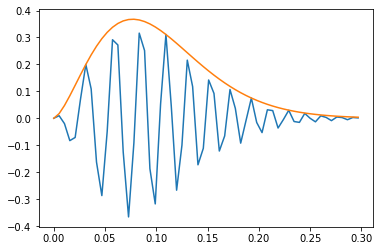

In [565]:
import numpy as np
import matplotlib.pyplot as plt

def zcSig(tt,f0,fm,aa,bb,cc):
    return (aa*tt)**bb * np.exp(-(aa*tt)**cc + 2*np.pi*1j*(f0+fm*tt)*tt)

fs=192 #kHz
ts=0.3 #ms
tt=np.arange(0,ts,1/fs)

f0=30
fm=60
aa=13
bb=1.5
cc=1.5
ss=zcSig(tt,f0,fm,aa,bb,cc)

plt.plot(tt,np.real(ss));
plt.plot(tt,np.abs(ss));

In [566]:
# hydrophones

isel,DI,nc,ho = hydrophones('cVAS')

In [567]:
az=0
bd=900 #m
hd=500 #m
sd=800 #m
dx=5000 #m
#
r1=np.sqrt(dx**2 + (hd-sd)**2)
r2=np.sqrt(dx**2 + (hd+sd)**2)
dr = r2-r1
dt = dr/1.5

a1=1
a2=-0.5*r1/r2

el1=np.arctan2(hd-sd,dx)
el2=np.arctan2(hd+sd,dx)

#print(np.array([r1,r2,dr,dt]))
print('Angles: ',np.array([az,el1,el2])*180/np.pi)
print('Time delay: ',dt)

Angles:  [ 0.         -3.43363036 14.5742162 ]
Time delay:  104.82975112567874


Simulate now the time delays of the hydrophone measurements that one should expect for given source geometry and acoustic paths

In [568]:
#hydrophone delay simulation
S1=np.array([np.cos(az)*np.cos(el1),np.sin(az)*np.cos(el1), np.sin(el1)])
S2=np.array([np.cos(az)*np.cos(el2),np.sin(az)*np.cos(el2), np.sin(el2)])
DC1=np.sum(ho*S1,1)
DC2=np.sum(ho*S2,1)
DT1=DC1/1.500
DT2=DC2/1.500

define and check fractional signal delay 

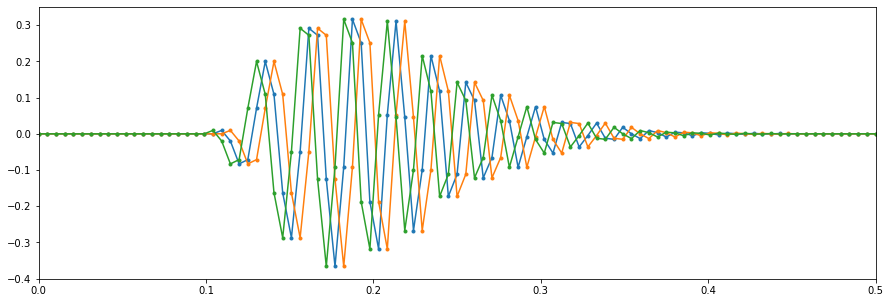

In [569]:
import scipy.signal as signal

fs=192 #kHz
ts=0.5 #ms
tt=np.arange(0,ts,1/fs)

f0=30
fm=60
aa=13
bb=1.5
cc=1.5
ss=zcSig(tt,f0,fm,aa,bb,cc)

#see also http://www.labbookpages.co.uk/audio/beamforming/fractionalDelay.html#filter
def delay(xx,tau):
    #tau = -4.5 # Fractional delay [samples].
    N = 21     # Filter length.
    n = np.arange(N)
    
    # Compute sinc filter.
    h = np.sinc(n - (N - 1) / 2 - tau)
    
    # Multiply sinc filter by window
    h *= np.blackman(N)
    
    # Normalize to get unity gain.
    h /= np.sum(h)

    uu=np.concatenate((xx,np.zeros(10,)))

    yy=signal.lfilter(h,1,uu); yy=yy[10:,]
    return yy

uu=np.concatenate((np.zeros(20,),np.real(ss)))
tu=np.arange(len(uu))/fs

fig = plt.figure("figure.figsize",[15,5])
dto=1
x0=delay(uu,0)
plt.plot(tu,x0,'.-')

x1=delay(uu,+dto)
plt.plot(tu,x1,'.-')

x2=delay(uu,-dto)
plt.plot(tu,x2,'.-')
plt.xlim(0,0.5);


Simulate the multi channel acoustic measurements using franctional delay

[ 5.32764206 -2.33857115 -2.33857115  2.33857115 -5.32764206  2.33857115]
[ 4.04423938 -3.38863747 -3.38863747  3.38863747 -4.04423938  3.38863747]
105.86979166666667
[ 4.35645551 -3.07642134 -3.07642134  3.7008536  -3.73202325  3.7008536 ]


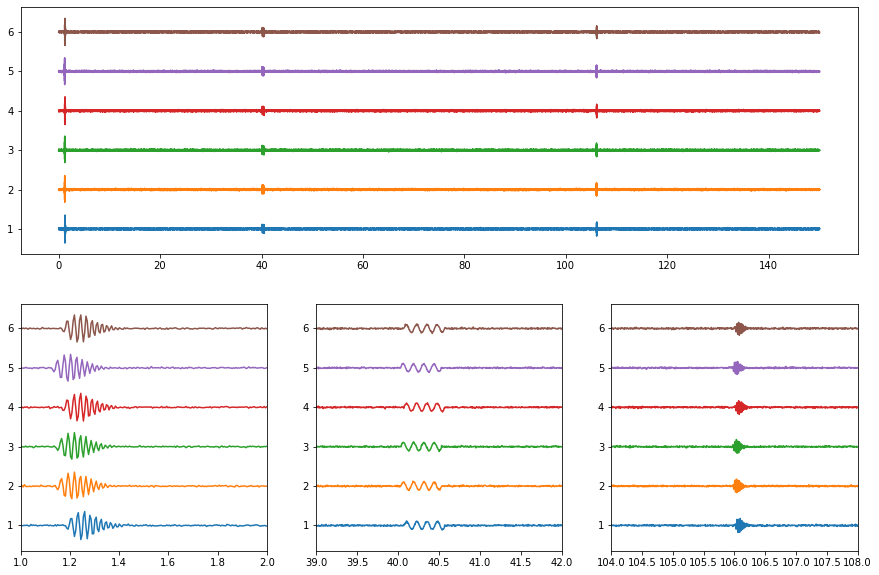

In [570]:
te=150 # ms
tx=np.arange(0,te,1/fs)

nh=6
ndat=len(tx)

tj1=(DT1*fs-np.floor(DT1*fs))
tj2=((dt+DT2)*fs-np.floor((dt+DT2)*fs))
print(DT1*fs)
print(DT2*fs)
#
j1=200
j2=j1+int(np.mean((dt+DT2)*fs))
DT2x=((dt+DT2)*fs-j2+j1)/fs
print(j2/fs)
print(DT2x*fs)
#
j3=40*fs
fo=8
rr=0*uu
rr[10:10+95]=np.sin(2*np.pi*np.arange(95)/fs*fo)
#
ju=len(uu)
xx=np.empty((ndat,nh))
for ii in range(nh):
    xx[:,ii]=np.random.normal(0, 0.01, len(tx))
    xx[j1:j1+ju,ii] =xx[j1:j1+ju,ii] +a1*delay(uu,DT1[ii]*fs)
    xx[j2:j2+ju,ii] =xx[j2:j2+ju,ii] +a2*delay(uu,DT2x[ii]*fs)
    xx[j3:j3+ju,ii] =xx[j3:j3+ju,ii] +a1/10*delay(rr,DT2[ii]*fs)

# prepare plot
fig = plt.figure("figure.figsize",[15,10])
plt.subplot(211)
plt.plot(tx,xx+np.ones((ndat,1))*range(1,7));
plt.subplot(234)
plt.plot(tx,xx+np.ones((ndat,1))*range(1,7));
plt.xlim(1, 2);
plt.subplot(235)
plt.plot(tx,xx+np.ones((ndat,1))*range(1,7));
plt.xlim(39, 42);
plt.subplot(236)
plt.plot(tx,xx+np.ones((ndat,1))*range(1,7));
plt.xlim(104, 108);

process all data channels using spectrogram method

224
(129, 224, 6)
(0.6666666666666666, 149.33333333333334, 0.0, 96.0)
(129, 224)


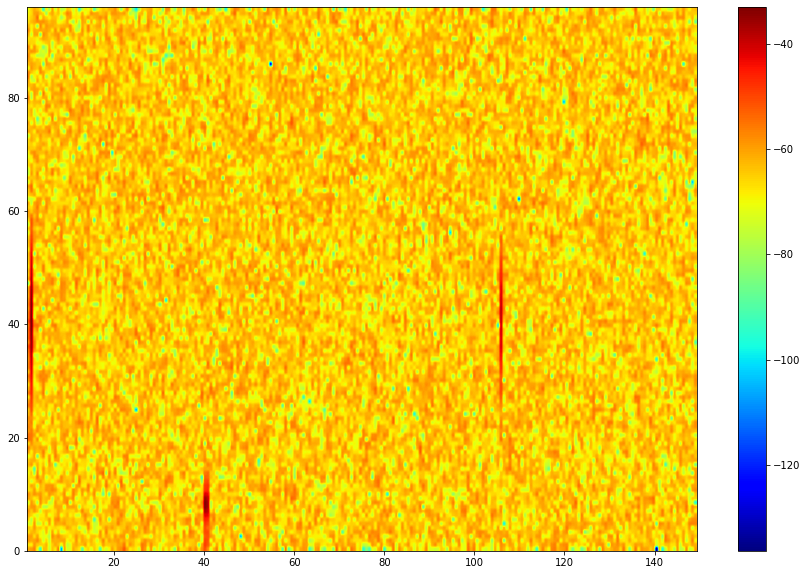

In [571]:
from scipy import signal

#ndat=np.shape(xx)[0]
#nh=6

nw=256
nfft=nw
nf=1+int(nfft/2)
nt=1+int(np.ceil((ndat-nw)/(nw-nw/2)))

P=np.zeros((nf,nt,nh),dtype=complex)
for ii in range(6):
    fp,tp,P[:,:,ii]=signal.stft(xx[:,ii],fs,nperseg=nw,nfft=nfft,boundary=None)

print(nt)
print(np.shape(P))
t_ext=(tp[0], tp[-1], fp[0],fp[-1])
print(t_ext)
#
M=np.squeeze(np.abs(P[:,:,1]))
print(np.shape(M))

fig=plt.figure('figure.figsize',[15,10])
im1=plt.imshow(20*np.log10(M),extent=t_ext, origin='lower',cmap=plt.cm.jet, aspect='auto')
plt.colorbar(im1,orientation='vertical');


Cross correlate hydrophone pairs (proportional to complex division)

In [572]:
#cross correlation
M=np.zeros((nf,nt,nc),dtype=complex)
for ii in range(nc):
    M[:,:,ii]=P[:,:,isel[ii,1]]*np.conj(P[:,:,isel[ii,0]])


Check sign of cross corelation with delay

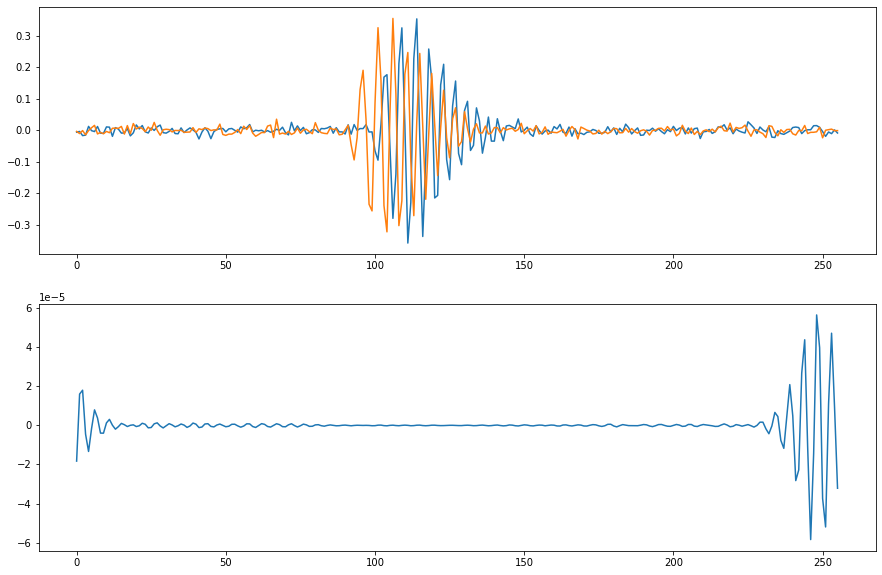

In [573]:
nfft=256
ii=1
jj=range(ii*128,ii*128+nfft)
u0=xx[jj,0];
u1=xx[jj,1];
vv=np.fft.irfft(M[:,1,0]);

fig=plt.figure('figure.figsize',[15,10])
plt.subplot(211)
plt.plot(u0)
plt.plot(u1)
plt.subplot(212)
plt.plot(vv);

channel 1 (u1) is earlier with respect to channel 0 (u0), so that 'delay' is negative (> nfft/2)

Crosscorrelate all hydrophone pairs for single time step

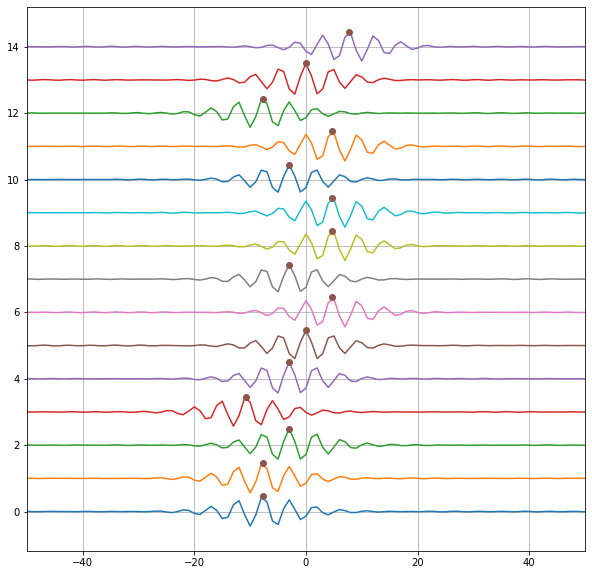

In [574]:
def quadInt(uu,imx,nd1,nc):
    ux=np.zeros((nc,2))
    for ii in range(nc):
        uo=uu[imx[ii],ii]
        um=uu[imx[ii]-1,ii]
        up=uu[imx[ii]+1,ii]

        b=(up+um-2*uo)/2;

        xo=(um-up)/(4*b);
        yo=uo-b*xo**2;

        xo += imx[ii]-nd1/2;
        ux[ii,0]=xo
        ux[ii,1]=yo
    return ux

ii=1;
A=np.zeros((nfft,nc))
for kk in range(nc):
    A[:,kk] = np.fft.fftshift(np.fft.irfft(M[:,ii,kk]));

imx=np.argmax(A,0)
udel=quadInt(A,imx,nfft,nc)

fig=plt.figure('figure.figsize',[10,10])

sc=0.5/np.max(A)
plt.plot(np.arange(nfft)-nfft/2, A*sc+np.ones((nfft,1))*range(nc));
plt.plot(udel[:,0] ,udel[:,1]*sc+np.arange(nc),'o');
plt.xlim(-50,50);
plt.grid(True)


Crosscorrelate over all hydrophone pairs and time steps

(223, 15, 2)
(129, 224, 6)


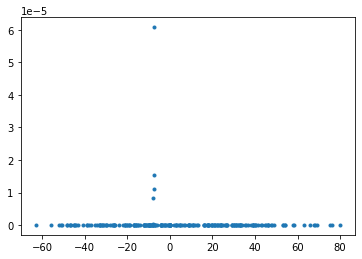

In [575]:
nfft=256
nf=int(nfft/2+1)
ns=int(2*(len(xx)-nfft)/nfft)
acor=np.zeros((ns,nc,2))
print(np.shape(acor))
print(np.shape(P))

A = np.zeros((nfft,nc))
for ii in range(ns):
    io=ii*128
    jj=range(io,io+nfft)
    for kk in range(nc):
        for kk in range(nc):
            A[:,kk] = np.fft.fftshift(np.fft.irfft(M[:,ii,kk]));

        imx = np.argmax(A,0)
        acor[ii,:,:] = quadInt(A,imx,nfft,nc)

plt.plot(acor[:,0,0],acor[:,0,1],'.');


Combine all crosscorrelations to obtain direction vectors 

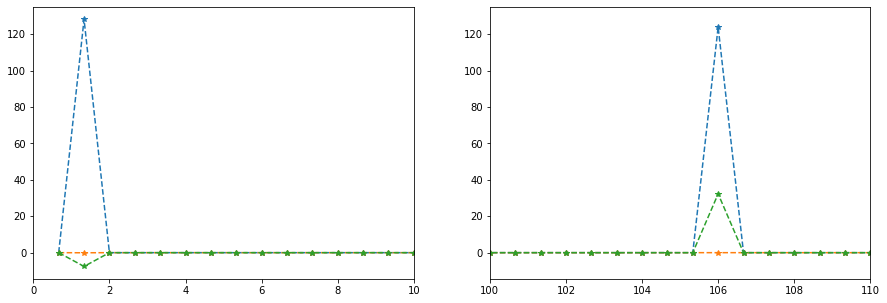

In [576]:
B=np.zeros((ns,3,2))

for ii in range(ns):
    B[ii,:,:]=np.matmul(DI,acor[ii,:,:])

fig=plt.figure('figure.figsize',[15,5])

bn=np.sqrt(np.sum(B[:,:,1]**2,1))
iu=bn<1e-5
B[iu,:,0]=0
plt.subplot(121)
plt.plot(tp[:-1],B[:,:,0],'*--');
plt.xlim(0,10);
plt.subplot(122)
plt.plot(tp[:-1],B[:,:,0],'*--');
plt.xlim(100,110);

Estimate signal directions from direction vectors

-3.380307728724366 15.021214097807565 14.59893617188952
-3.4336303624505224 14.574216198038739 14.574216198038739


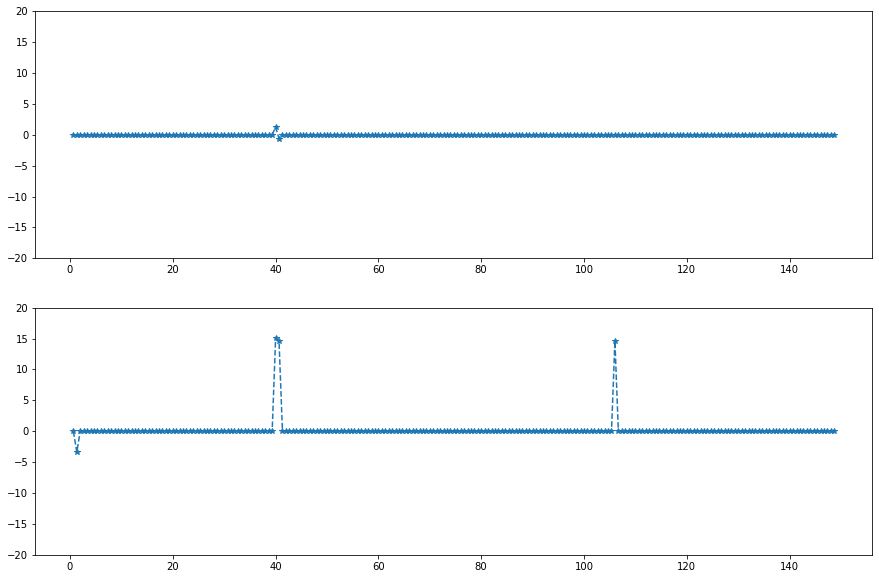

In [582]:
azi=np.arctan2(B[:,1,0],B[:,0,0])*180/np.pi
ele=np.arctan2(B[:,2,0],np.sqrt(B[:,0,0]**2+B[:,1,0]**2))*180/np.pi

fig=plt.figure('figure.figsize',[15,10])
plt.subplot(211)
plt.plot(tp[:-1],azi,'*--')
plt.ylim(-20,20)
plt.subplot(212)
plt.plot(tp[:-1],ele,'*--')
plt.ylim(-20,20)
print(min(ele[:10]),max(ele[40:100]),max(ele[100:]))
print(el1*180/np.pi, el2*180/np.pi, el2*180/np.pi)

Direction finding using sound intensity

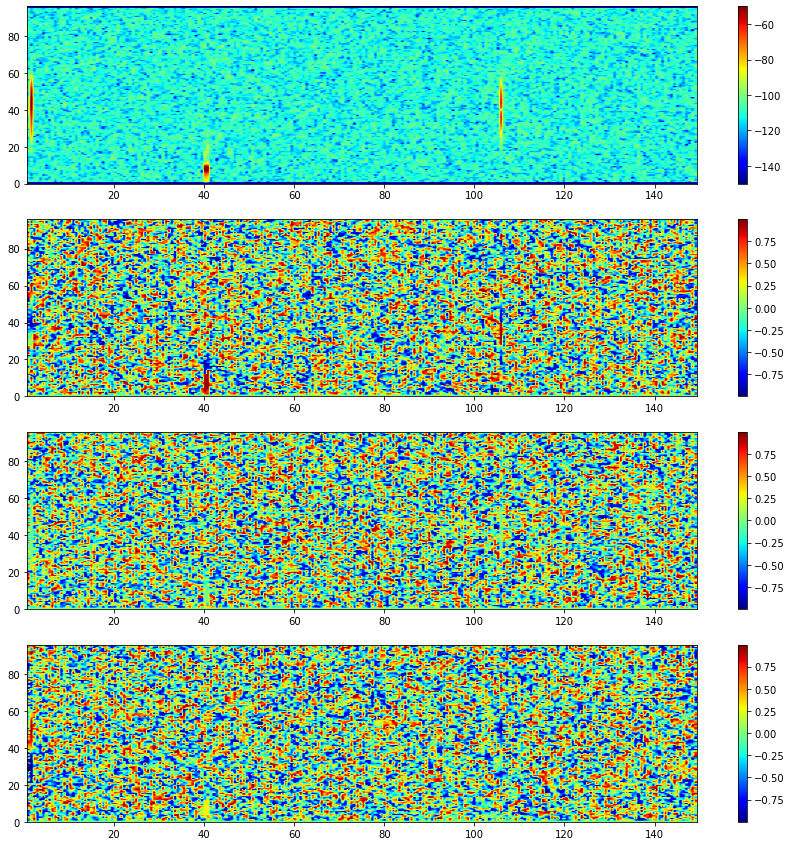

In [578]:
#intensities
I=np.zeros((nf,ns+1,4))

for ii in range(nc):
    MI=-np.imag(M[:,:,ii])
    I[:,:,0]=I[:,:,0]+ DI[0,ii]*MI
    I[:,:,1]=I[:,:,1]+ DI[1,ii]*MI
    I[:,:,2]=I[:,:,2]+ DI[2,ii]*MI

I[:,:,3]=np.sqrt(np.sum(I**2,2))
I[0,:,3]=1e-10 #make DC intensity non-zero to avoid inf
I[-1,:,3]=1e-10 #make Nyquist intensity non-zero to avoid inf

for ii in range(3):
    I[:,:,ii]=I[:,:,ii]/I[:,:,3]

#
fig=plt.figure('figure.figsize',[15,15])
plt.subplot(411)
im1=plt.imshow(20*np.log10(I[:,:,3]),extent=t_ext, origin='lower',cmap=plt.cm.jet, clim=(-150,-50), aspect='auto')
cb1 = plt.colorbar(im1, orientation='vertical')
plt.subplot(412)
im2=plt.imshow(I[:,:,0],extent=t_ext, origin='lower',cmap=plt.cm.jet, aspect='auto')
cb2 = plt.colorbar(im2, orientation='vertical')
plt.subplot(413)
im3=plt.imshow(I[:,:,1],extent=t_ext, origin='lower',cmap=plt.cm.jet, aspect='auto')
cb3 = plt.colorbar(im3, orientation='vertical')
plt.subplot(414)
im4=plt.imshow(I[:,:,2],extent=t_ext, origin='lower',cmap=plt.cm.jet, aspect='auto')
cb4 = plt.colorbar(im4, orientation='vertical')
